In [81]:
import pandas as pd

In [82]:
## df = pd.read_csv("spotify_millsongdata.csv")
df_tracks = pd.read_csv("user_top_tracks.csv")
df_artists = pd.read_csv("user_top_artists.csv")
df_albums = pd.read_csv("user_top_albums.csv")

df_tracks.head()

,user_id,rank,track_name,artist_name,playcount,mbid
0,1,1,Ice Cream,New Young Pony Club,54,417a3d0b-0291-4e08-b167-50971dbdae36
1,1,2,Hiding On The Staircase,New Young Pony Club,51,f6ac2fd2-b33b-48ff-a094-537cf530cf20
2,1,3,Descend,New Young Pony Club,49,33434fd1-79a1-3882-bb31-fbd430815a93
3,1,4,Air War,Crystal Castles,48,06d3fea3-e806-35ed-9562-aa396a97de14
4,1,5,Get Lucky,New Young Pony Club,48,ab351b25-7126-3792-9b0d-ce44fd0c0462


In [83]:
df_tracks.tail()

,user_id,rank,track_name,artist_name,playcount,mbid
23822545,479484,46,teeth,Loser,192,NaN
23822546,479484,47,MISA MISA!,Corpse,191,NaN
23822547,479484,48,title track,Machine Gun Kelly,191,b9874074-b2d6-4135-bc2a-f4ef44b0ae69
23822548,479484,49,В последний раз,Tima Belorusskih,190,NaN
23822549,479484,50,fantasize,ericdoa,189,NaN


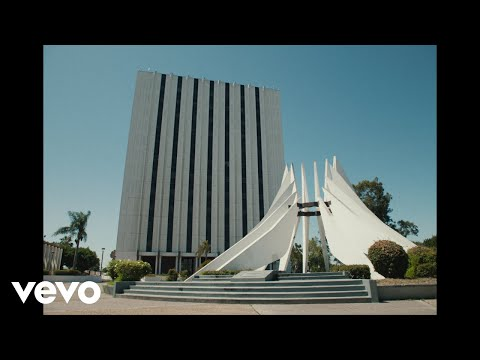

In [84]:
from IPython.display import YouTubeVideo

title = "Not Like Us"

result = YoutubeSearch(title, max_results=1).to_dict()
YouTubeVideo(result[0]['id'], width=600, height=300)

In [353]:
def top_N_songs(user, N):
    return df_tracks.loc[df_tracks["user_id"] == user]["track_name"].tolist()[0:N], df_tracks.loc[df_tracks["user_id"] == user]["artist_name"].tolist()[0:N]

def top_N_artists(user, N):
    return df_artists.loc[df_artists["user_id"] == user]["artist_name"].tolist()[0:N]

def top_N_albums(user, N):
    return df_albums.loc[df_albums["user_id"] == user]["album_name"].tolist()[0:N], df_albums.loc[df_albums["user_id"] == user]["artist_name"].tolist()[0:N]

print(top_N_artists(50, 10))

['Modest Mouse', 'Wintersleep', 'Wolf Parade', 'Pavement', 'Pixies', 'Eels', 'The Weakerthans', 'TV on the Radio', 'Radiohead', 'Stars']


In [355]:
def shared_songs(user1, user2):
    song_list, artist_list = [], []
    user1_songs, user2_songs = top_N_songs(user1, 50)[0], top_N_songs(user2, 50)[0]
    user1_artists, user2_artists = top_N_songs(user1, 50)[1], top_N_songs(user2, 50)[1]
    for i in range(50):
        song, artist = user1_songs[i], user1_artists[i]
        if song in user2_songs:
            song_list.append(song)
            artist_list.append(artist)
    return song_list, artist_list

def shared_artists(user1, user2):
    artist_list = []
    user1_artists, user2_artists = top_N_artists(user1, 50), top_N_artists(user2, 50)
    for artist in user1_artists:
        if artist in user2_artists:
            artist_list.append(artist)
    return artist_list

def shared_albums(user1, user2):
    album_list, artist_list = [], []
    user1_albums, user2_albums = top_N_albums(user1, 50)[0], top_N_albums(user2, 50)[0]
    user1_artists, user2_artists = top_N_albums(user1, 50)[1], top_N_albums(user2, 50)[1]
    for i in range(50):
        album, artist = user1_albums[i], user1_artists[i]
        if album in user2_albums:
            album_list.append(album)
            artist_list.append(artist)
    return album_list, artist_list

def artist_songs(artist):
    songs_by_artist = df_tracks.loc[df_tracks["artist_name"] == artist, "track_name"].tolist()
    rand_songs = random.sample(songs_by_artist, 3)
    return rand_songs

In [435]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def similarity_to_songs(user, songs):
    songs_list = " ".join(songs)
    user_songs = " ".join(top_N_songs(user, 10)[0])

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([user_songs, songs_list])
    
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

def user_similarity(user1, user2):
    songs_list = " ".join(top_N_songs(user1, 10)[0])
    user_songs = " ".join(top_N_songs(user2, 10)[0])

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([user_songs, songs_list])
    
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

print(user_similarity(67, 94))

0.1362360288173473


In [469]:
import random

user_ids = df_tracks["user_id"].unique().tolist()

def song_recommender(songs, N = 5):
    temp = []
    users = []
    extras = []
    for song in songs:
        if(" | " in song):
            parts = song.split(" | ", 1)
            users += df_tracks.loc[(df_tracks["track_name"].str.lower() == parts[0].lower()) & (df_tracks["artist_name"].str.lower() == parts[1].lower()), "user_id"].tolist()
            extras.append(parts[0])
        else:
            users += df_tracks.loc[df_tracks["track_name"].str.lower() == song.lower(), "user_id"].tolist()
    while(len(temp) < N):
        rand = random.sample(users, 2)
        r1, r2 = rand[0], rand[1]
        if(user_similarity(r1, r2) > 0.05):
            rand_songs = shared_songs(r1, r2)
            if(len(rand_songs[0]) == 0):
                continue
            rand = random.randint(0, len(rand_songs[0]) - 1)
            rand_song = rand_songs[0][rand]
            rand_artist = rand_songs[1][rand]
            if(rand_song not in [song[0] for song in temp] and rand_song.lower() not in [item.lower() for item in songs] and rand_song.lower() not in [item.lower() for item in extras]):
                temp.append([rand_song, rand_artist])
    show_songs(temp)

def artist_recommender(artists, N):
    temp = []
    users = []
    for artist in artists:
        users += df_artists.loc[df_artists["artist_name"].str.lower() == artist.lower(), "user_id"].tolist()
    while(len(temp) < N):
        rand = random.sample(users, 2)
        r1, r2 = rand[0], rand[1]
        rand_artists = shared_artists(r1, r2)
        if(len(rand_artists) == 0):
            continue
        rand_artist = random.sample(rand_artists, 1)[0]
        if(rand_artist not in temp and rand_artist.lower() not in [item.lower() for item in artists]):
            temp.append(rand_artist)
    for artist in temp:
        string = "\"" + artist + "\" with songs: "
        string += "; ".join(artist_songs(artist))
        print(string)
    print("\n")

def album_recommender(albums, N):
    temp = []
    users = []
    for album in albums:
        users += df_albums.loc[df_albums["album_name"].str.lower() == album.lower(), "user_id"].tolist()
    while(len(temp) < N):
        rand = random.sample(users, 2)
        r1, r2 = rand[0], rand[1]
        rand_albums = shared_albums(r1, r2)
        if(len(rand_albums[0]) == 0):
            continue
        rand = random.randint(0, len(rand_albums[0]) - 1)
        rand_album = rand_albums[0][rand]
        rand_artist = rand_albums[1][rand]
        if(rand_album not in [album[0] for album in temp] and rand_album.lower() not in [item.lower() for item in albums]):
            temp.append([rand_album, rand_artist])
    for album in temp:
        print("\"", album[0], "\" by ", album[1])
    print("\n")

def show_songs(songs):
    for song in songs:
        print("\"", song[0], "\" by ", song[1])
        video_id = YoutubeSearch(song[0] + " " + song[1], max_results=1).to_dict()
        video = YouTubeVideo(video_id[0]["id"], width=400, height=300)
        display(video)

In [295]:
artist_recommender(["Taylor Swift", "Lana Del Ray", "Olivia Rodrigo", "Sabrina Carpenter"], 5)

"Adele" with songs: Set Fire to the Rain; Chasing Pavements; Don't You Remember
"Queen" with songs: Bohemian Rhapsody - Remastered 2011; A Kind of Magic; I Want to Break Free
"Selena Gomez" with songs: People You Know; Stars Dance; Forget Forever
"Lorde" with songs: Buzzcut Season; Royals; Royals
"The Weeknd" with songs: Twenty Eight; Starboy; Faith




In [329]:
album_recommender(["Mezzanine", "Modal Soul", "Melody A.M.", "Sleep"], 5)

" Spiritual State " by  Nujabes
" The Dark Side of the Moon " by  Pink Floyd
" Deathconsciousness " by  Have a Nice Life
" OK Computer " by  Radiohead
" The Very Best Of " by  Led Zeppelin




In [461]:
import random
import numpy as np

def avg_pair_similarity(user_list):
    sims = []
    for i in range(len(user_list)):
        for j in range(i+1, len(user_list)):
            sims.append(similarity_between_users(user_list[i], user_list[j]))
    return np.mean(sims) if sims else 0

def similarity_between_users(u1, u2):
    v1 = tfidf_matrix[user_id_to_idx[u1]]
    v2 = tfidf_matrix[user_id_to_idx[u2]]
    return cosine_similarity(v1, v2)[0,0]

def evaluate_user_selection():
    chosen = []
    for _ in range(3):
        uid = random.choice(user_ids)
        chosen.append(uid)

    random_users = random.sample(user_ids, 3)

    chosen_sim = avg_pair_similarity(chosen)
    rand_sim = avg_pair_similarity(random_users)

    print("Model-picked user pair similarity:", chosen_sim)
    print("Random user pair similarity:", rand_sim)

def artist_overlap(seed_songs, rec_songs):
    seed_artists = {s.split(" | ")[1].lower() for s in seed_songs if " | " in s}
    rec_artists  = {a.lower() for _, a in rec_songs}

    if not rec_artists:
        return 0

    return len(seed_artists & rec_artists) / len(rec_artists)

seeds = ["Empire Ants | Gorillaz"]
recs = song_recommender(seeds, N=5)

print("Artist Overlap:", artist_overlap(seeds, recs))

Artist Overlap: 0.25


In [463]:
def make_label(row):
    return f"{row['track_name']} | {row['artist_name']}"

df_tracks["label"] = df_tracks.apply(make_label, axis=1)

import random
import numpy as np

def precision_at_k(model_func, k=10, num_users=50, test_fraction=0.2):
    user_groups = df_tracks.groupby("user_id")["label"].apply(list)

    # pick users with at least k+3 songs
    test_users = [u for u, songs in user_groups.items() if len(songs) > k+3]
    random.shuffle(test_users)
    test_users = test_users[:num_users]

    precisions = []

    for u in test_users:
        songs = user_groups[u]
        random.shuffle(songs)

        # split into train & test (implicit feedback)
        cutoff = int(len(songs) * (1 - test_fraction))
        train_songs = songs[:cutoff]
        test_songs = set(songs[cutoff:])

        # get model recommendations
        recommendations = model_func(train_songs, k)
        rec_labels = {f"{t} | {a}" for (t, a) in recommendations}

        # compute hits
        hits = len(rec_labels & test_songs)
        precision = hits / k
        precisions.append(precision)

    return np.mean(precisions), precisions

mean_prec10, all_precisions = precision_at_k(song_recommender, k=10)
print("Precision@10:", mean_prec10)

KeyboardInterrupt: 

In [465]:
import random

user_ids = df_tracks["user_id"].unique().tolist()

def song_recommender(songs, N=5, min_sim=0.01,
                     max_user_tries=2000, max_song_tries=10000):
    temp = []
    users = []
    extras = []   # you can plug your old extras logic back in if needed

    # ---- 1. Pick similar users (bounded attempts) ----
    tries = 0
    while len(users) < 3 and tries < max_user_tries:
        candidate_id = random.choice(user_ids)
        tries += 1

        if similarity_to_songs(candidate_id, songs) > min_sim:
            if candidate_id not in users:
                users.append(candidate_id)

    # If we couldn't find at least 2 users, we can't form pairs
    if len(users) < 2:
        # print("Warning: not enough similar users found")
        return []

    # ---- 2. Sample shared songs (bounded attempts) ----
    tries = 0
    while len(temp) < N and tries < max_song_tries:
        tries += 1

        r1, r2 = random.sample(users, 2)
        rand_songs = shared_songs(r1, r2)  # expect (titles, artists)

        if len(rand_songs[0]) == 0:
            continue

        idx = random.randint(0, len(rand_songs[0]) - 1)
        rand_song = rand_songs[0][idx]
        rand_artist = rand_songs[1][idx]

        # filters
        if rand_song in [song[0] for song in temp]:
            continue
        if rand_song.lower() in [item.lower() for item in songs]:
            continue
        if rand_song.lower() in [item.lower() for item in extras]:
            continue

        temp.append([rand_song, rand_artist])

    # It's okay if we return fewer than N; that just means not many valid songs
    return temp

mean_prec10, all_precisions = precision_at_k(song_recommender,
                                             k=10,
                                             num_users=5,  # small!
                                             test_fraction=0.2)
print("Precision@10:", mean_prec10)

KeyboardInterrupt: 

In [273]:
def grab_songs(seed_text: str) -> str:
    global last_ui_songs

    # One song per line, strip empty lines
    songs = [line.strip() for line in seed_text.split("\n") if line.strip()]
    last_ui_songs = songs  # store in global so we can use them later

    if not songs:
        return "No songs captured. Please enter at least one song."

    # Nice summary message
    joined = "\n".join(f"- {s}" for s in songs)
    return f"Captured {len(songs)} song(s):\n{joined}"

In [283]:
with gr.Blocks() as demo:
    gr.Markdown(
        """
        # 🎵 Song Input UI

        Enter the songs you like (one per line), then click **Capture Songs**.  
        After that, you can use the `last_ui_songs` variable in your notebook to feed into `song_recommender`.
        """
    )

    song_box = gr.Textbox(
        lines=6,
        label="Seed songs",
        placeholder="One song per line, e.g.:\nAmerican Pie\nLollipop | Mika"
    )

    capture_button = gr.Button("Capture Songs 🎧")
    status = gr.Textbox(label="Status / Captured Songs", interactive=False)

    capture_button.click(
        fn=grab_songs,
        inputs=song_box,
        outputs=status
    )

In [285]:
demo.launch()

* Running on local URL:  http://127.0.0.1:7874
* To create a public link, set `share=True` in `launch()`.


" Shake It Off " by  Taylor Swift


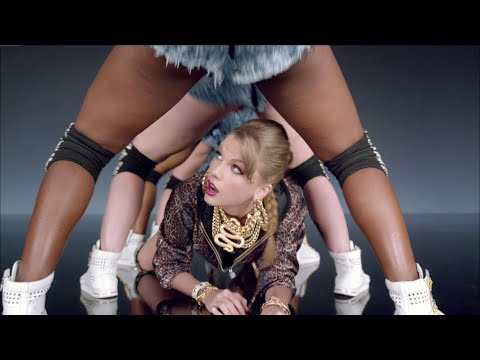

" Delicate " by  Taylor Swift


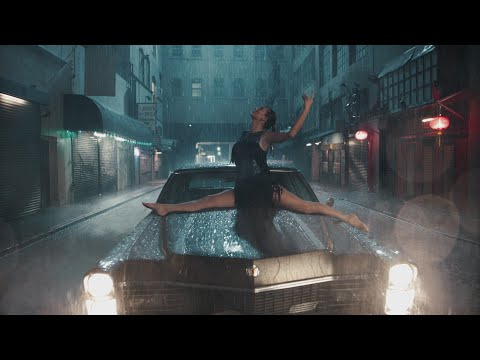

" Bad Blood " by  Taylor Swift


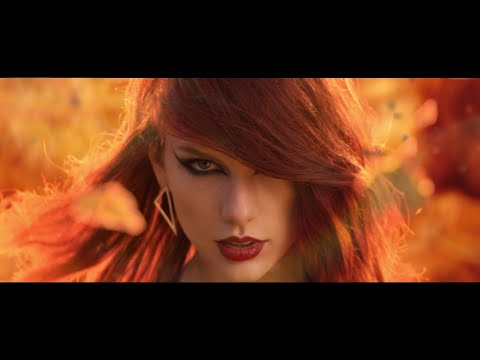

" Wildest Dreams " by  Taylor Swift


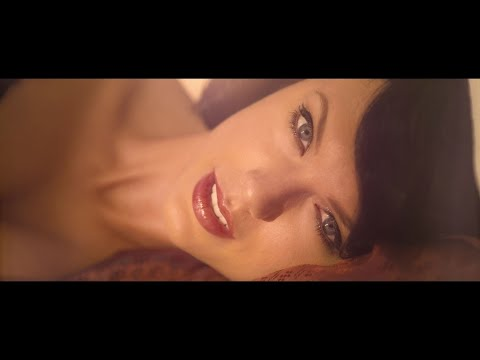

" Born This Way " by  Lady Gaga


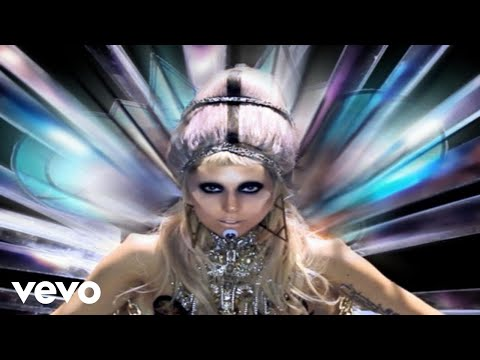

In [473]:
song_recommender(last_ui_songs, 5)